# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
from scipy import stats as st
from numpy.random import RandomState
import matplotlib.pyplot as plt
from heapq import nlargest

Прочитаем файлы.

In [2]:
geo_0 = pd.read_csv('/datasets/geo_data_0.csv')                    
geo_1 = pd.read_csv('/datasets/geo_data_1.csv')                    
geo_2 = pd.read_csv('/datasets/geo_data_2.csv')                    

Напишем функцию, которая будет выводить:
- общую информацию про файл,
- покажет содержание файла,
- покажет наименование столбцов, 
- покажет есть ли дубликаты.

In [3]:
def inform(geo_x):                                                 # введем функцию для получения информации из файла
    geo_x.info()                                                   # общая информация про файл
    display(geo_x.head(5))                                         # смотрим содержание файла
    print("Наименование столбцов:", geo_x.columns)                 # смотрим наименование столбцов
    print()
    print("Количество дубликатов: ", geo_x.duplicated().sum())     # смотрим, есть ли дубликаты    

### Подготовим файл geo_0

In [4]:
inform(geo_0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


Наименование столбцов: Index(['id', 'f0', 'f1', 'f2', 'product'], dtype='object')

Количество дубликатов:  0


### Подготовим файл geo_1

In [5]:
inform(geo_1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


Наименование столбцов: Index(['id', 'f0', 'f1', 'f2', 'product'], dtype='object')

Количество дубликатов:  0


### Подготовим файл geo_2

In [6]:
inform(geo_2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Наименование столбцов: Index(['id', 'f0', 'f1', 'f2', 'product'], dtype='object')

Количество дубликатов:  0


Проводем корреляционный анализ и построим графики для целевого признака.

In [7]:
corr = geo_0.corr()
corr.style.background_gradient(cmap='coolwarm')

,f0,f1,f2,product
f0,1,-0.440723,-0.00315334,0.143536
f1,-0.440723,1,0.00172443,-0.192356
f2,-0.00315334,0.00172443,1,0.483663
product,0.143536,-0.192356,0.483663,1


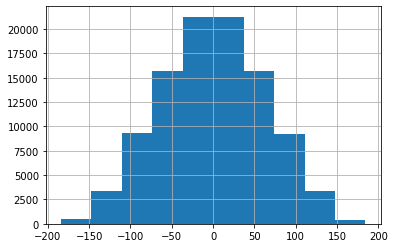

In [8]:
plt.figure()
geo_0["product"].diff().hist()                               

In [9]:
corr = geo_1.corr()
corr.style.background_gradient(cmap='coolwarm')

,f0,f1,f2,product
f0,1,0.182287,-0.00177704,-0.0304905
f1,0.182287,1,-0.00259532,-0.0101549
f2,-0.00177704,-0.00259532,1,0.999397
product,-0.0304905,-0.0101549,0.999397,1


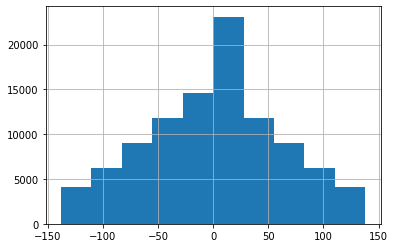

In [10]:
plt.figure();
geo_1["product"].diff().hist();

In [11]:
corr = geo_2.corr()
corr.style.background_gradient(cmap='coolwarm')

,f0,f1,f2,product
f0,1,0.000528283,-0.000448133,-0.00198706
f1,0.000528283,1,0.000778661,-0.00101239
f2,-0.000448133,0.000778661,1,0.445871
product,-0.00198706,-0.00101239,0.445871,1


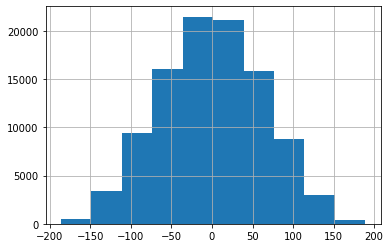

In [12]:
plt.figure();
geo_2["product"].diff().hist();

По корреляции не видно сильных зависимостей, кроме F2 и product во 2-м регионе - практически 1 (единица), так как дынные не настоящие может это сделано специально, для получения необходимых результатов. 

По графикам видим нормальное распределение, но во 2-м регионе явный пик на уровне 0-25.

### Вывод

На первом этапе было выполнено:
- загрузка и изучение файлов,
- увидели, что во всех файлах пропущенных значений нет, 
- посмотрели, что название столбцов правильное, 
- увидели, что в каждом файле по 5 столбцоа и 10000 строк. 

Так как по условию проекта необходимо выбрать 1 из 3 регионов, то столбец id (уникальный идентификатор скважины) нем не потребуется, удалим его на следующем шаге.

## Обучение и проверка модели

In [13]:
def to_split(position):
    target = position['product']
    features = position.drop(['product', "id"], axis=1)
    features_train, features_valid, target_train, target_valid = train_test_split(features, target,
                                                                                  test_size=0.25, random_state=12345)
    model =  LinearRegression()
    model.fit(features_train, target_train)
        
    return pd.Series(model.predict(features_valid)), target_valid

In [14]:
predicted_valid_0, target_valid_0 = to_split(geo_0)
predicted_valid_1, target_valid_1 = to_split(geo_1)
predicted_valid_2, target_valid_2 = to_split(geo_2)

In [15]:
to_split(geo_0)

(0         95.894952
 1         77.572583
 2         77.892640
 3         90.175134
 4         70.510088
             ...    
 24995    103.037104
 24996     85.403255
 24997     61.509833
 24998    118.180397
 24999    118.169392
 Length: 25000, dtype: float64,
 71751     10.038645
 80493    114.551489
 2655     132.603635
 53233    169.072125
 91141    122.325180
             ...    
 12581    170.116726
 18456     93.632175
 73035    127.352259
 63834     99.782700
 43558    177.821022
 Name: product, Length: 25000, dtype: float64)

In [16]:
to_split(geo_1)

(0         82.663314
 1         54.431786
 2         29.748760
 3         53.552133
 4          1.243856
             ...    
 24995    136.869211
 24996    110.693465
 24997    137.879341
 24998     83.761966
 24999     53.958466
 Length: 25000, dtype: float64,
 71751     80.859783
 80493     53.906522
 2655      30.132364
 53233     53.906522
 91141      0.000000
             ...    
 12581    137.945408
 18456    110.992147
 73035    137.945408
 63834     84.038886
 43558     53.906522
 Name: product, Length: 25000, dtype: float64)

In [17]:
to_split(geo_2)

(0         93.599633
 1         75.105159
 2         90.066809
 3        105.162375
 4        115.303310
             ...    
 24995     78.765887
 24996     95.603394
 24997     99.407281
 24998     77.779912
 24999    129.032417
 Length: 25000, dtype: float64,
 71751     61.212375
 80493     41.850118
 2655      57.776581
 53233    100.053761
 91141    109.897122
             ...    
 12581     28.492402
 18456     21.431303
 73035    125.487229
 63834     99.422903
 43558    127.445075
 Name: product, Length: 25000, dtype: float64)

In [18]:
def get_mean_predict_rmse (target_valid, predicted_valid):
    mean_predict = predicted_valid.mean()
    rmse = mean_squared_error(target_valid,predicted_valid)**0.5
    print("Средний запас предсказанного сырья:", mean_predict, "RMSE модели:", rmse)    

In [19]:
print("Регион № 1")
get_mean_predict_rmse (predicted_valid_0, target_valid_0)
print()
print("Регион № 2")
get_mean_predict_rmse (predicted_valid_1, target_valid_1)
print()
print("Регион № 3")
get_mean_predict_rmse (predicted_valid_2, target_valid_2)

Регион № 1
Средний запас предсказанного сырья: 92.07859674082927 RMSE модели: 37.5794217150813

Регион № 2
Средний запас предсказанного сырья: 68.72313602435997 RMSE модели: 0.893099286775616

Регион № 3
Средний запас предсказанного сырья: 94.88423280885438 RMSE модели: 40.02970873393434


### Вывод

На этом этапе было сделано:
- данные разбиты на обучающую и валидационную выборки в соотношении 75:25
- обучена модель и сделаны предсказания на валидационной выборке
- сохранены предсказания и правильные ответы на валидационной выборке
- получены значения среднего запаса предсказанного сырья и RMSE модели.

По полученным значениям видим, что меньше всего среднего запаса предсказанного сырья во 2-ом регионе (68 против 92 и 94), но точность модели в этом регионе лучше всего  - 0,89! Против 37 и 40 на других регионах. То есть полученные значения во 2-ом регионе максимально достоверные.

## Подготовка к расчёту прибыли

In [20]:
Point = 200                                         # количество отбираемых месторождений 
Budget = 10000000000                                # бюджет на разработку
Profit = 450000                                     # доход с месторождения
Mean_profit = Budget/ Profit / Point                # минимальный запас нефти в месторождении для окупаемости
Mean_profit_2 = Budget/ Profit                      # минимальный запас нефти в регионе для окупаемости
pro_of_loss = 0.025                                 # вероятность убытков

In [21]:
print("Минимальный запас нефти в месторождении для окупаемости:",  Mean_profit)
print("Минимальный запас нефти в регионе для окупаемости:",  Mean_profit_2)

Минимальный запас нефти в месторождении для окупаемости: 111.11111111111111
Минимальный запас нефти в регионе для окупаемости: 22222.222222222223


### Вывод

Получили средние значения запаса нефти по месторождениям всех 3-х регионов и видим, что все они ниже чем минимальный запас нефти для окупаемости, равный 111 тыс.баррелей.

## Расчёт прибыли и рисков 

Так как для работы берутся только 200 лучших месторождений в каждом регионе, а считали мы по всем, выберем лучшие 200 скважин и посмотрим запас в них

In [22]:
state = np.random.RandomState(777)

In [23]:
def revenue(target, predicted):
    target = pd.Series(target).reset_index(drop=True)
    predicted = pd.Series(predicted).reset_index(drop=True)
    probs_sorted = predicted.sort_values(ascending=False)
    selected = target[probs_sorted.index][:Point]                   # 200 месторождений
    # print ("Целевое значение объёма сырья, соответствующее предсказаниям, тыс.баррелей:", sum(selected))
    # print("Прибыль для полученного объёма сырья, млрд.рублей:", ((Profit * selected.sum()) - Budget) / 1000000000)
    return ((Profit * selected.sum()) - Budget) / 1000000000

In [24]:
revenue (target_valid_0, predicted_valid_0)

3.3208260431398524

In [25]:
revenue (target_valid_1, predicted_valid_1)

2.4150866966815108

In [26]:
revenue (target_valid_2, predicted_valid_2)

2.7103499635998327

In [27]:
def bootstrap (target, predicted):
    values = []
    for i in range(1000):
        target_subsample = target.reset_index(drop=True).sample(n=500, replace=True, random_state=state)        
        probs_subsample = predicted[target_subsample.index] 
        rev = revenue(target_subsample, probs_subsample)
        values.append(rev)

    values = pd.Series(values)
    
    mean = values.mean()
    intervf = values.quantile(pro_of_loss)
    intervs = values.quantile(0.975)
    confidence_interval = st.t.interval(0.95, len(values)-1, values.mean(), values.sem())
        
    confidence_interval_prognoz = (values.quantile(0.025), values.quantile(0.975))                           
        
    print("Средняя выручка:", mean)
    print("2,5%-квантиль:", intervf)
    print("97,5%-квантиль:", intervs)
    print("Доверительный интервал истинного среднего:", confidence_interval)
    print("Доверительный интервал для прогноза (2,5% и 97.5% квантили):", confidence_interval_prognoz)      
    print("Риск убытка:",((values < 0).mean()))

In [28]:
bootstrap (target_valid_0, predicted_valid_0)

Средняя выручка: 0.3850465428284363
2,5%-квантиль: -0.12315555346401204
97,5%-квантиль: 0.8542964008648799
Доверительный интервал истинного среднего: (0.3691482211521802, 0.4009448645046924)
Доверительный интервал для прогноза (2,5% и 97.5% квантили): (-0.12315555346401204, 0.8542964008648799)
Риск убытка: 0.074


In [29]:
bootstrap (target_valid_1, predicted_valid_1)

Средняя выручка: 0.4429657248719404
2,5%-квантиль: 0.04531659356088114
97,5%-квантиль: 0.8566698771156019
Доверительный интервал истинного среднего: (0.4303009627298333, 0.4556304870140475)
Доверительный интервал для прогноза (2,5% и 97.5% квантили): (0.04531659356088114, 0.8566698771156019)
Риск убытка: 0.016


In [30]:
bootstrap (target_valid_2, predicted_valid_2)

Средняя выручка: 0.39522042415916575
2,5%-квантиль: -0.1460756684273435
97,5%-квантиль: 0.9239512491249194
Доверительный интервал истинного среднего: (0.3778507223385934, 0.4125901259797381)
Доверительный интервал для прогноза (2,5% и 97.5% квантили): (-0.1460756684273435, 0.9239512491249194)
Риск убытка: 0.085


### Выбор региона и вывод

Для выбора региона необходимо выбрать регион, в котором будет больше:
- средняя выручка
- доверительный интервал

    и в котором будет меньше риск убытка.
    
Учитывая это, видим что регион № 2 лучший, его параметры:
- средняя выручка: 0.4429657248719404 (против 0.3850465428284363 и 0.39522042415916575)
- доверительный интервал: (0.4303009627298333, 0.4556304870140475) - против (0.3691482211521802, 0.4009448645046924) и (0.3778507223385934, 0.4125901259797381)
- риск убытка: 0.016 (против 0.074 и 0.085)

При этом на этапе получения "среднего запаса предсказанного сырья" получили, что во 2-ом регионе запасы на 30 тыс.баррелей меньше, чем в других регионах и если бы решение о разработке было принято по данным этого этапа фирма "ГлавРосГосНефть" получила бы меньшую прибыль.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [X]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [X]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован